In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../../datasets/result_predict_draid.csv")
df

,path,lung lesion GT,threshold prob,output prob,threshold
0,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,3.948788,0.7
1,/vinbrain/datasets/private/vinmec/anonymized-i...,0,0,-2.277747,0.7
2,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.233110,0.7
3,/vinbrain/datasets/private/vinmec/anonymized-i...,0,0,-3.908599,0.7
4,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,4.431159,0.7
...,...,...,...,...,...
5010,/vinbrain/datasets/private/vinmec/anonymized-i...,0,0,-3.908338,0.7
5011,/vinbrain/datasets/private/vinmec/anonymized-i...,0,1,1.580423,0.7
5012,/vinbrain/datasets/private/vinmec/anonymized-i...,0,0,-3.551871,0.7
5013,/vinbrain/datasets/private/vinmec/anonymized-i...,0,0,-1.513944,0.7


In [59]:
from __future__ import division
import matplotlib.pyplot as plt


def AdaptiveBinning(infer_results, show_reliability_diagram = True):
	'''
	This function implement adaptive binning. It returns AECE, AMCE and some other useful values.

	Arguements:
	infer_results (list of list): a list where each element "res" is a two-element list denoting the infer result of a single sample. res[0] is the confidence score r and res[1] is the correctness score c. Since c is either 1 or 0, here res[1] is True if the prediction is correctd and False otherwise.
	show_reliability_diagram (boolean): a boolean value to denote wheather to plot a Reliability Diagram.

	Return Values:
	AECE (float): expected calibration error basezd on adaptive binning.
	AMCE (float): maximum calibration error based on adaptive binning.
	cofidence (list): average confidence in each bin.
	accuracy (list): average accuracy in each bin.
	cof_min (list): minimum of confidence in each bin.
	cof_max (list): maximum of confidence in each bin.

	'''

	# Intialize.
	infer_results.sort(key = lambda x : x[0], reverse = True)
	n_total_sample = len(infer_results)

	assert infer_results[0][0] <= 1 and infer_results[1][0] >= 0, 'Confidence score should be in [0,1]'

	z=1.645
	num = [0 for i in range(n_total_sample)]
	final_num = [0 for i in range(n_total_sample)]
	correct = [0 for i in range(n_total_sample)]
	confidence = [0 for i in range(n_total_sample)]
	cof_min = [1 for i in range(n_total_sample)]
	cof_max = [0 for i in range(n_total_sample)]
	accuracy = [0 for i in range(n_total_sample)]
	
	ind = 0
	target_number_samples = float('inf')

	# Traverse all samples for a initial binning.
	for i, confindence_correctness in enumerate(infer_results):
		confidence_score = confindence_correctness[0]
		correctness = confindence_correctness[1]
		# Merge the last bin if too small.
		if num[ind] > target_number_samples:
			if (n_total_sample - i) > 40 and cof_min[ind] - infer_results[-1][0] > 0.05:
				ind += 1
				target_number_samples = float('inf')
		num[ind] += 1
		confidence[ind] += confidence_score

		assert correctness in [True,False], 'Expect boolean value for correctness!'
		if correctness == True:
			correct[ind] += 1

		cof_min[ind] = min(cof_min[ind], confidence_score)
		cof_max[ind] = max(cof_max[ind], confidence_score)
		# Get target number of samples in the bin.
		if cof_max[ind] == cof_min[ind]: 
			target_number_samples = float('inf')
		else:
			target_number_samples = (z / (cof_max[ind] - cof_min[ind])) ** 2 * 0.25

	n_bins = ind + 1

	# Get final binning.
	if target_number_samples - num[ind] > 0:
		needed = target_number_samples - num[ind]
		extract = [0 for i in range(n_bins - 1)]
		final_num[n_bins - 1] = num[n_bins - 1]
		for i in range(n_bins - 1):
			extract[i] = int(needed * num[ind] / n_total_sample)
			final_num[i] = num[i] - extract[i]
			final_num[n_bins - 1] += extract[i]
	else:
		final_num = num
	final_num = final_num[:n_bins]

	# Re-intialize.
	num = [0 for i in range(n_bins)]	
	correct = [0 for i in range(n_bins)]
	confidence = [0 for i in range(n_bins)]
	cof_min = [1 for i in range(n_bins)]
	cof_max = [0 for i in range(n_bins)]
	accuracy = [0 for i in range(n_bins)]
	gap = [0 for i in range(n_bins)]
	neg_gap = [0 for i in range(n_bins)]
	# Bar location and width.
	x_location = [0 for i in range(n_bins)]
	width = [0 for i in range(n_bins)]


	# Calculate confidence and accuracy in each bin.
	ind = 0
	for i, confindence_correctness in enumerate(infer_results):

		confidence_score = confindence_correctness[0]
		correctness = confindence_correctness[1]
		num[ind] += 1
		confidence[ind] += confidence_score

		if correctness == True:
			correct[ind] += 1
		cof_min[ind] = min(cof_min[ind], confidence_score)
		cof_max[ind] = max(cof_max[ind], confidence_score)

		if num[ind] == final_num[ind]:
			confidence[ind] = confidence[ind] / num[ind] if num[ind] > 0 else 0
			accuracy[ind] = correct[ind] / num[ind] if num[ind] > 0 else 0
			left = cof_min[ind]
			right = cof_max[ind]
			x_location[ind] = (left + right) / 2
			width[ind] = (right - left) * 0.9
			if confidence[ind] - accuracy[ind] > 0:
				gap[ind] = confidence[ind] - accuracy[ind]
			else:
				neg_gap[ind] = confidence[ind] - accuracy[ind]
			ind += 1

	# Get AECE and AMCE based on the binning.
	AMCE = 0
	AECE = 0
	for i in range(n_bins):
		AECE += abs((accuracy[i] - confidence[i])) * final_num[i] / n_total_sample
		AMCE = max(AMCE, abs((accuracy[i] - confidence[i])))


	# Plot the Reliability Diagram if needed.
	if show_reliability_diagram:
		f1,ax = plt.subplots()
		plt.bar(x_location, accuracy, width)
		plt.bar(x_location, gap,width, bottom = accuracy)
		plt.bar(x_location, neg_gap,width, bottom = accuracy)
		plt.legend(['Accuracy','Positive gap','Negative gap'], fontsize=18, loc=2)
		plt.xlim(0, 1)
		plt.ylim(0, 1)
		plt.xlabel('Confidence', fontsize=15)
		plt.ylabel('Accuracy', fontsize=15)
		plt.show()

	return AECE, AMCE, cof_min, cof_max, confidence, accuracy


In [70]:
from __future__ import division
import numpy as np

def softmax(x):
    """Compute softmax for x on axis 1."""
    return np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)

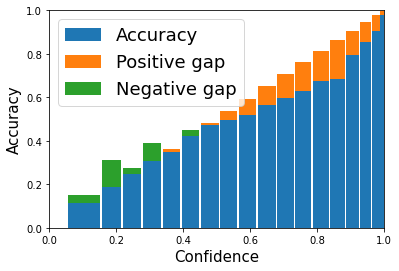

ECE based on adaptive binning: 0.05228912244409627
MCE based on adaptive binning: 0.17985050479821352


In [71]:
# raw_output.npy simply save the raw ouput before softmax of a network. Its shape is (m,n) where m is the numner of samples and n is the number of classes.
import numpy as np
data = np.load('/home/tuananh/tuananh/AdaptiveBinning/raw_output.npy')

probability = softmax(data[:, 1:])
prediction = np.argmax(probability, axis=1)
label = data[:, 0]

infer_results = []

for i in range(len(data)):
	correctness = (label[i] == prediction[i])
	infer_results.append([probability[i][prediction[i]], correctness])

# Call AdaptiveBinning.
AECE, AMCE, confidence, accuracy, cof_min, cof_max = AdaptiveBinning(infer_results, True)

print('ECE based on adaptive binning: {}'.format(AECE))
print('MCE based on adaptive binning: {}'.format(AMCE))

In [102]:
df = pd.read_csv("../../../datasets/result_predict_draid.csv")
df = df[df["lung lesion GT"] == 1]
df

,path,lung lesion GT,threshold prob,output prob,threshold
0,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,3.948788,0.7
2,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.233110,0.7
4,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,4.431159,0.7
10,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,3.476563,0.7
11,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.653250,0.7
...,...,...,...,...,...
4981,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,1.749769,0.7
4984,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,1.624273,0.7
4989,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,4.285386,0.7
4990,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.486983,0.7


In [103]:
import numpy as np
import math

# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def threshold_filter(x):
    if x > 0.7:
        return 1
    else:
        return 0

sigmoid_v = np.vectorize(sigmoid)
threshold_filter_v = np.vectorize(threshold_filter)

logits = df['output prob'].values
labels = df["lung lesion GT"].values
probabilities = sigmoid_v(logits)
predictions = threshold_filter_v(probabilities)
predictions

array([1, 1, 1, ..., 1, 1, 1])

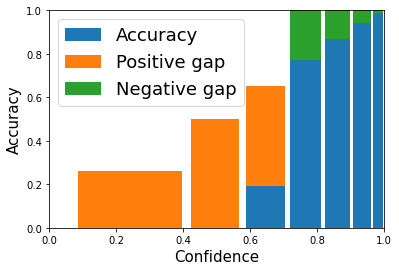

ECE based on adaptive binning: 0.09143763936392019
MCE based on adaptive binning: 0.5003605117496314


In [104]:
infer_results = []

for i in range(df.shape[0]):
	correctness = (labels[i] == predictions[i])
	infer_results.append([probabilities[i], correctness])

# Call AdaptiveBinning.
AECE, AMCE, confidence, accuracy, cof_min, cof_max = AdaptiveBinning(infer_results, True)

print('ECE based on adaptive binning: {}'.format(AECE))
print('MCE based on adaptive binning: {}'.format(AMCE))

# Scale

In [124]:
df = pd.read_csv("/home/tuananh/tuananh/calibrate_model/datasets/result_predict_draid_scale_exp0.csv")
df = df[df["lung lesion GT"] == 1]
T = 0.5625
df["output prob scale"] = df["output prob"] / T
df

,path,lung lesion GT,threshold prob,output prob,threshold,output prob scale,threshold prob scale,f1 score,best threshold
0,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,3.948788,0.7,7.020068,1,0.630025,0.1
2,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.233110,0.7,3.969974,1,0.630025,0.1
4,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,4.431159,0.7,7.877616,1,0.630025,0.1
10,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,3.476563,0.7,6.180556,1,0.630025,0.1
11,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.653250,0.7,4.716889,1,0.630025,0.1
...,...,...,...,...,...,...,...,...,...
4981,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,1.749769,0.7,3.110700,1,0.630025,0.1
4984,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,1.624273,0.7,2.887597,1,0.630025,0.1
4989,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,4.285386,0.7,7.618464,1,0.630025,0.1
4990,/vinbrain/datasets/private/vinmec/anonymized-i...,1,1,2.486983,0.7,4.421302,1,0.630025,0.1


In [125]:
# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def threshold_filter(x):
    if x > 0.7:
        return 1
    else:
        return 0
    
sigmoid_v = np.vectorize(sigmoid)
threshold_filter_v = np.vectorize(threshold_filter)

logits = df['output prob scale'].values
labels = df["lung lesion GT"].values
probabilities = sigmoid_v(logits)
predictions = threshold_filter_v(probabilities)
predictions

array([1, 1, 1, ..., 1, 1, 1])

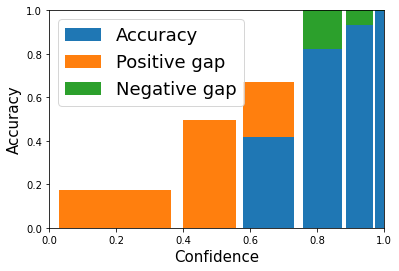

ECE based on adaptive binning: 0.042150942142183595
MCE based on adaptive binning: 0.49587271187971693


In [126]:
infer_results = []

for i in range(df.shape[0]):
	correctness = (labels[i] == predictions[i])
	infer_results.append([probabilities[i], correctness])

# Call AdaptiveBinning.
AECE, AMCE, confidence, accuracy, cof_min, cof_max = AdaptiveBinning(infer_results, True)

print('ECE based on adaptive binning: {}'.format(AECE))
print('MCE based on adaptive binning: {}'.format(AMCE))